
# Wstęp

## Cel ćwiczenia

Celem ćwiczenia jest **wytrenowanie od podstaw sieci typu MLP (Multi-Layer Perceptron)** oraz **analiza wpływu wybranych dobrych praktyk** stosowanych w deep learningu na proces uczenia i jakość uzyskiwanych wyników.
W trakcie zadania będziemy świadomie podejmować decyzje projektowe dotyczące architektury, przygotowania danych oraz procesu treningu.


# Ogólne informacje do zadania

### 1. Zbiór danych

W zadaniu wykorzystany zostanie zbiór **FashionMNIST**, który jest dostępny domyślnie w bibliotece `torchvision`.

Przy pierwszym uruchomieniu notebooka zbiór danych zostanie pobrany na dysk lokalny.
W tym celu należy ustawić flagę `download=True` oraz wskazać odpowiednią ścieżkę w parametrze `root`.

> **Uwaga:**
> W przypadku korzystania z Google Colab zaleca się podłączenie Google Drive, aby uniknąć ponownego pobierania danych przy każdym uruchomieniu środowiska.

Przykładowy kod do pobrania danych (można go modyfikować):

```python
from torchvision import datasets

trainset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)
```

Zbiór FashionMNIST służy do **klasyfikacji obrazów należących do 10 różnych klas odpowiadającym elementom garderoby** (np. koszulka, płaszcz, but itp).
Nie jest to zbiór przesadnie trudny, natomiast jego plusem jest szybki czas przetwarzania.

### UWAGA
Jeśli ktoś chciałby mieć większe wyzwanie to polecam przeprowadzić rozwiązania na zbiorze [CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvisiondatasets.CIFAR10.html), który nie jest już tak trywialnym zbiorem (dalej ma obrazki i 10 klas, natomiast klasyfikacja jest trudniejsza oraz czas przetwarzania, będzie większy). Jest on również dostępny w `torchvision.datasets` przez co pobiera go się go w analogiczny sposób co MNIST





### 2. Trenowanie sieci MLP

Celem zadania jest wykorzystanie zdobytej wiedzy z zakresu implementacji modeli w **PyTorch** lub **PyTorch Lightning** do wytrenowania sieci składającej się z kilku warstw liniowych (stąd nazwa **Multi-Layer Perceptron**).

Model będzie używany do klasyfikacji obrazów, mimo że:

* dla danych obrazowych **znacznie lepiej sprawdzają się sieci konwolucyjne (CNN)**,
* MLP nie wykorzystuje informacji o strukturze przestrzennej obrazu.

Świadomie ograniczamy się tutaj do MLP, ponieważ:

* pozwala to skupić się na **uniwersalnych dobrych praktykach**, które będą opisane poniżej:
* ułatwia zrozumienie **dlaczego i w jaki sposób CNN przewyższają MLP** w zadaniach wizji komputerowej.

Dopiero po zaobserwowaniu ograniczeń klasycznej sieci MLP możliwe jest pełne docenienie zalet architektur konwolucyjnych, które zostaną omówione w kolejnych zadaniach.

W ramach teorii potrzebnej do zrozumienia na czym polega uczenie sieci MLP, bardzo mocno polecam pierwsze 4 rozdziały z playlist [Neural Networks 3Blue 1Brown](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi), która w świetny sposób tłumaczy to zagadnienie. Dodatkowo jeśli ktoś nie czuje się do końca dobrze z algorytmem propagacji wstecznej, to również polecam obejrzeć.




### 3. Wykorzystanie dobrych praktyk w trakcie uczenia modelu

W poprzedniej liście zadań trenowaliście **pojedynczy perceptron**, który można uznać za bardzo prostą sieć neuronową.
Proces uczenia polegał głównie na doborze podstawowych hiperparametrów, takich jak:

* liczba epok,
* współczynnik uczenia (*learning rate*).

Dodatkowo wykorzystywany był **zbiór walidacyjny**, który pozwalał obserwować wartość funkcji straty na danych niewidzianych przez model w trakcie uczenia.
Jest to kluczowy element oceny zdolności modelu do **generalizacji**, czyli sprawdzenia, czy model nie uczy się na pamięć danych treningowych (*overfitting*).

W praktycznych zastosowaniach deep learningu stosuje się jednak **szereg dodatkowych technik**, które:

* stabilizują proces uczenia,
* poprawiają generalizację,
* ułatwiają analizę i debugowanie modeli.

W ramach tego zadania będziecie musieli **zrozumieć wszystkie poniższe techniki** oraz przebadać wpływ części z nich na proces uczenia.

---

#### 3.1 Monitorowanie `val_loss` i zapisywanie najlepszego modelu

Podczas treningu wartość straty na zbiorze walidacyjnym (`val_loss`) **nie zawsze maleje monotonicznie**.
Często model osiąga najlepsze wyniki na danych walidacyjnych w pewnej epoce, po czym zaczyna się przeuczać.

Dlatego:

* w trakcie uczenia monitorujemy `val_loss`,
* zapisujemy parametry modelu z epoki, w której `val_loss` było **najniższe**,
* po zakończeniu treningu **ładujemy najlepszy zapisany model**, a nie ten z ostatniej epoki.

**Dlaczego to robimy?**

* minimalizujemy ryzyko overfittingu,
* wykorzystujemy model o najlepszej zdolności generalizacji,
* wynik końcowy nie zależy od arbitralnie dobranej liczby epok.

Technika ta jest często realizowana poprzez tzw. *checkpointing*.

---

#### 3.2 Early stopping

**Early stopping** to mechanizm, który **automatycznie przerywa trening**, jeśli jakość modelu na zbiorze walidacyjnym przestaje się poprawiać.

Działanie:

* obserwujemy `val_loss`,
* jeśli przez określoną liczbę epok (*patience*) nie nastąpi poprawa,
* trening zostaje zakończony.

**Dlaczego to robimy?**

* zapobiegamy przeuczeniu modelu,
* skracamy czas treningu,
* oszczędzamy zasoby obliczeniowe.

Early stopping jest szczególnie skuteczny w połączeniu z **zapisywaniem najlepszego modelu**, ponieważ zapewnia, że końcowy model pochodzi z najlepszego momentu treningu.

**Materiały**
- [Early stopping](https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf)

---

#### 3.3 Logowanie metryk i funkcji straty

W trakcie treningu należy logować:

* wartość funkcji straty (`loss`),
* metryki jakości (np. accuracy),
* zarówno dla zbioru treningowego, jak i walidacyjnego.

Logowanie może odbywać się:

* do **TensorBoarda**,
* lub w formie danych umożliwiających późniejsze narysowanie wykresów.

**Dlaczego to robimy?**

* umożliwia to wizualną analizę procesu uczenia,
* pozwala szybko wykryć problemy (np. overfitting, zbyt duży learning rate, niestabilne uczenie),
* ułatwia porównywanie różnych eksperymentów i konfiguracji modelu.

W praktyce logowanie jest jednym z podstawowych narzędzi pracy z modelami deep learningowymi.

---

#### 3.4 Regularizacja (L1, L2, Dropout)

Regularizacja ma na celu **ograniczenie nadmiernej złożoności modelu**, co poprawia jego zdolność generalizacji.

* **L1 (Lasso):**

  * dodaje do funkcji straty sumę wartości bezwzględnych wag:

$$
\begin{aligned}
 \lambda \sum_{i} |w_i|
\end{aligned}
$$


  * sprzyja rzadkim rozwiązaniom (wiele wag przyjmuje wartości bliskie zeru).

* **L2 (Ridge / weight decay):**

  * dodaje do funkcji straty sumę kwadratów wag:
$$
\begin{aligned}
    \lambda \sum_{i} w_i^2
\end{aligned}
$$

  * zapobiega nadmiernemu wzrostowi wag,

  * jest najczęściej stosowaną formą regularizacji w deep learningu.

* **Dropout:**

  * w trakcie treningu losowo „wyłącza” część neuronów,
  * zmusza sieć do uczenia się bardziej odpornych reprezentacji,
  * działa jak uśrednianie wielu modeli.

**Dlaczego to robimy?**

* zmniejszamy overfitting,
* poprawiamy stabilność uczenia,
* model lepiej generalizuje na nowe dane.

> **Uwaga:** regularizacja to hiperparametr – jej siłę należy dobrać eksperymentalnie.
> Zbyt silna regularizacja może prowadzić do *underfittingu*.

**Materiały pomocniczne**

* [regularyzacja L1 i L2](https://medium.com/@alejandro.itoaramendia/l1-and-l2-regularization-part-1-a-complete-guide-51cf45bb4ade)
* [dropout](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575)

---

#### 3.5 Harmonogram uczenia – Cosine Learning Rate Scheduling

Zamiast używać stałego learning rate, często stosuje się **harmonogram jego zmiany w czasie**.

**LR scheduling (np. Cosine Scheduling):**

* learning rate zmniejsza się zgodnie z krzywą cosinusa,
* na początku uczenie jest agresywne,
* pod koniec staje się bardzo delikatne.

Intuicyjnie:

* duży learning rate pomaga szybko znaleźć dobry obszar rozwiązań,
* mały learning rate pozwala dokładnie „dostroić” wagi.

**Dlaczego to robimy?**

* poprawiamy stabilność uczenia,
* często osiągamy lepsze minima funkcji straty,
* zmniejszamy potrzebę ręcznego doboru learning rate.

> W praktyce harmonogram uczenia często ma **większy wpływ na wynik końcowy** niż niewielkie zmiany architektury.

**Materiały**

* [cosine scheduling](https://medium.com/@utkrisht14/cosine-learning-rate-schedulers-in-pytorch-486d8717d541)

---

#### 3.6 Batch Normalization

**Batch Normalization (BatchNorm)** to technika polegająca na **normalizacji aktywacji w warstwach sieci neuronowej** w trakcie treningu.

Dla każdej cechy w mini-batchu:

* odejmowana jest średnia,
* dzielone jest przez odchylenie standardowe,
* a następnie stosowane są uczone parametry skali i przesunięcia.

Intuicyjnie:

* dane „wewnątrz sieci” mają stabilniejszy rozkład,
* kolejne warstwy dostają lepiej uwarunkowane wejście.

**Dlaczego to robimy?**

* stabilizujemy i przyspieszamy proces uczenia,
* umożliwiamy stosowanie większego learning rate,
* zmniejszamy wrażliwość modelu na inicjalizację wag,
* często poprawiamy generalizację (BatchNorm działa częściowo jak regularizacja).

**Ważne uwagi praktyczne:**

* BatchNorm **zachowuje się inaczej w trakcie treningu i inferencji**
  (używa statystyk batcha vs. statystyk zebranych podczas treningu).
* Nie zawsze jest konieczna- w małych sieciach lub przy bardzo małych batchach może **nie przynieść korzyści**.
* BatchNorm **nie jest zamiennikiem regularizacji** (np. Dropoutu), choć czasem może zmniejszyć jej potrzebę.

**Matariały**
- [Batch Normalization](https://medium.com/@piyushkashyap045/understanding-batch-normalization-in-deep-learning-a-beginners-guide-40917c5bebc8)

**UWAGA**
W praktyce nie dodajemy Batch Normalization „w ciemno” do każdej warstwy. Przy części problemów może ona okazać się bardzo pomocna i są pewne architektury które bez niej sobie nie są w stanie poradzić, ale dla prostych problemów jej wpływ może nie być wcale duży. Warto natomiast w każdym przypadku być świadomym, że coś takiego istnieje, ponieważ jest to techina bardzo szeroko stosowana.


# 4. Elementy architektury i treningu, o których należy pamiętać

Poza dobrymi praktykami związanymi z procesem uczenia (takimi jak early stopping, regularizacja czy harmonogram learning rate), istnieją również **podstawowe decyzje projektowe**, które są **ściśle związane z architekturą sieci oraz sposobem jej trenowania**.

Elementy te często mają **istotny wpływ na zbieżność uczenia, stabilność gradientów oraz końcową jakość modelu**, dlatego warto mieć ich istnienie na uwadze — nawet jeśli w tym zadaniu nie będą one głównym obiektem badań.

W szczególności należą do nich:

---

#### 4.1 Funkcje aktywacji

Funkcja aktywacji określa, w jaki sposób sygnał wyjściowy neuronu jest przekształcany i przekazywany do kolejnych warstw.
W praktyce deep learningu najczęściej spotyka się następujące, **bazowe funkcje aktywacji**:

* **Sigmoid**
  Historycznie bardzo popularna, obecnie rzadziej stosowana w warstwach ukrytych ze względu na problem zanikającego gradientu.

* **Tanh**
  Podobna do sigmoidy, ale o wyjściu symetrycznym względem zera; również może prowadzić do problemów z gradientami w głębokich sieciach.

* **ReLU (Rectified Linear Unit)**
  Najczęściej stosowana funkcja aktywacji w nowoczesnych sieciach neuronowych; prosta i skuteczna, sprzyja stabilnemu uczeniu.

Wybór funkcji aktywacji wpływa na dynamikę uczenia i może znacząco zmienić zachowanie modelu, nawet przy tej samej architekturze.


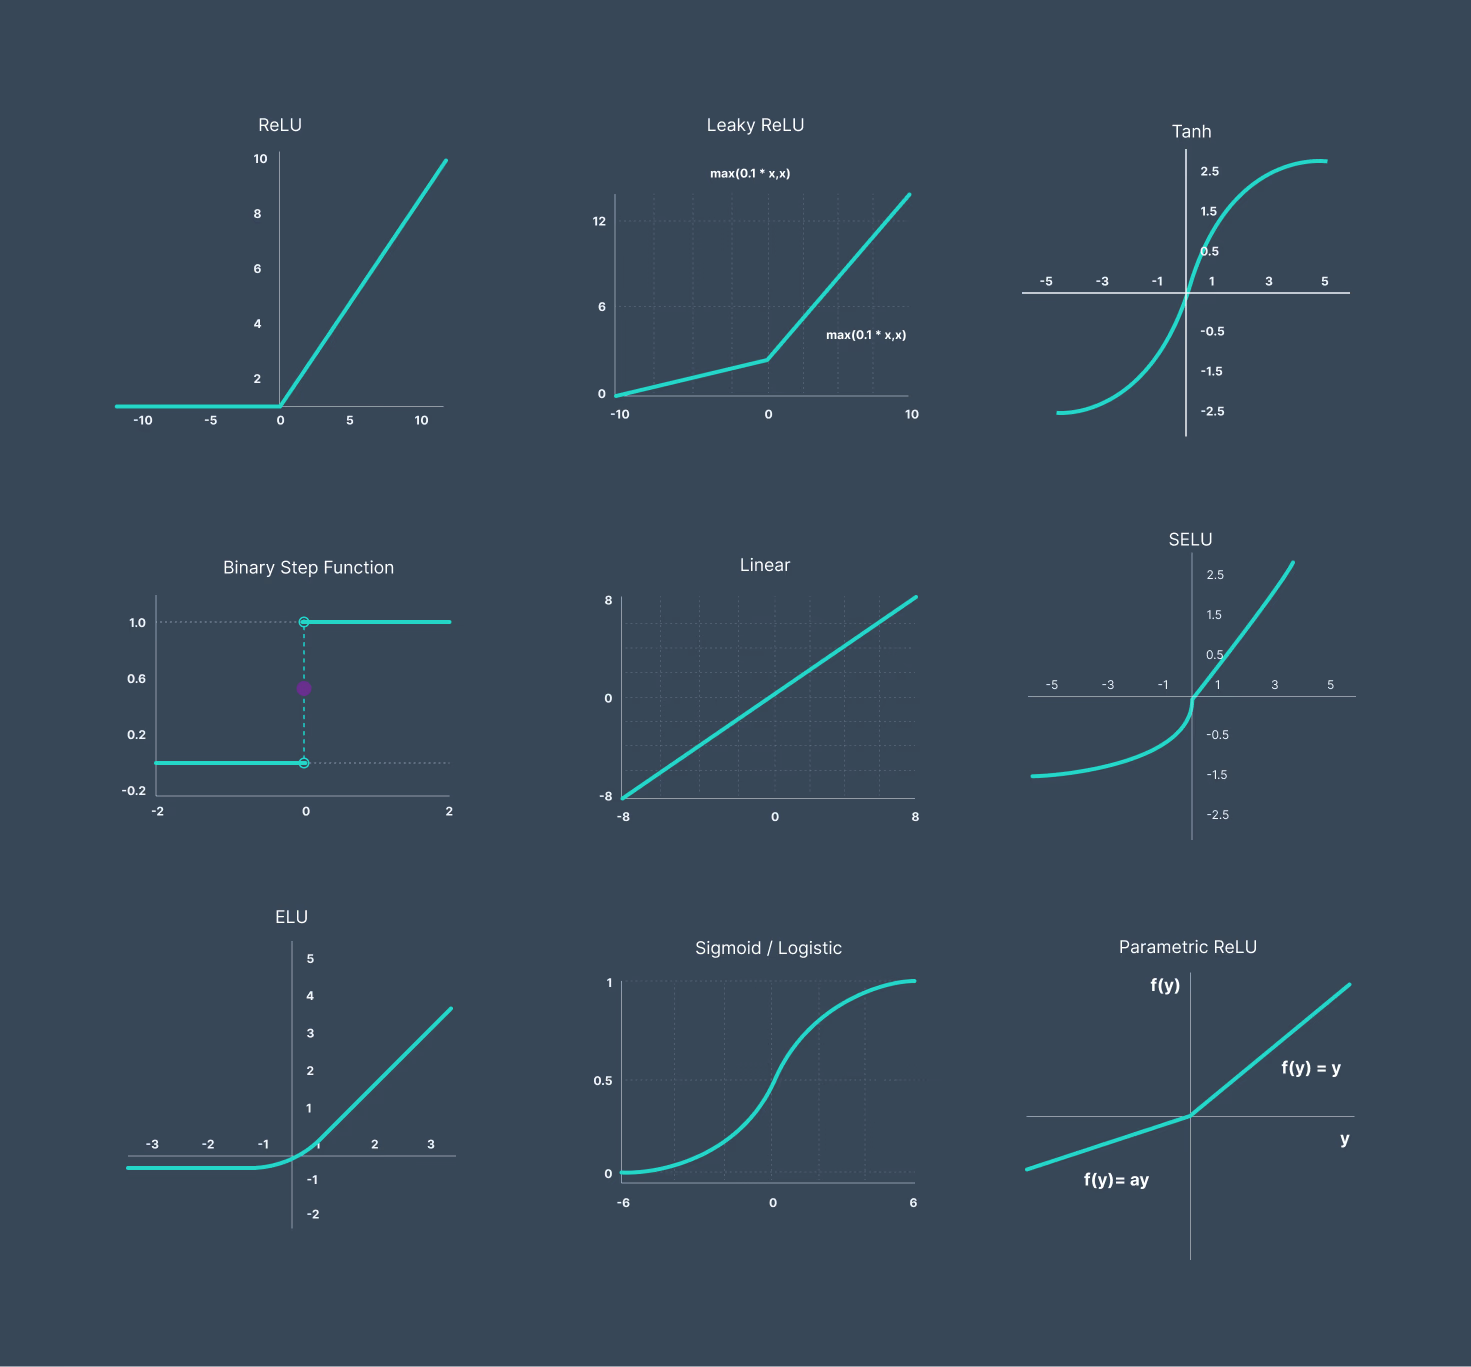


---

#### 4.2 Optymalizatory

Optymalizator określa, **w jaki sposób aktualizowane są wagi modelu** na podstawie obliczonych gradientów funkcji straty.

Do najczęściej stosowanych optymalizatorów należą:

* **SGD (Stochastic Gradient Descent)**
  Klasyczna metoda oparta bezpośrednio na gradiencie; często wymaga starannego doboru learning rate i dodatkowych technik (np. momentum).

* **[Adam](https://www.geeksforgeeks.org/deep-learning/adam-optimizer/)**
  Adaptacyjny optymalizator, który automatycznie dostosowuje learning rate dla poszczególnych parametrów; bardzo popularny ze względu na dobrą stabilność i szybkie zbieganie.


Wybór optymalizatora ma wpływ na szybkość uczenia, stabilność treningu oraz jakość znalezionego minimum funkcji straty. W praktyce wybór Adama jest zawsze dobrym wyborem i ciężko znaleźć kod który wybiera inny optymalizator. Kluczowe jednak jest wiedzieć, że tak jak większość optymalizatorów, mocno bazuje na SGD, dlatego warto być świadomym również jak działa ten klasyczny algorytm.
Z mniej znanych metod o których warto wspomnieć są [AdaGrad](https://www.geeksforgeeks.org/machine-learning/intuition-behind-adagrad-optimizer/), [RMSProp](https://medium.com/@piyushkashyap045/understanding-rmsprop-a-simple-guide-to-one-of-deep-learnings-powerful-optimizers-403baeed9922)





# KROKI DO WYKONANIA ZADANIA

W ramach zadania jesteście proszeni o wykonanie następujących kroków:

### 1. Przygotowanie danych

* Załadujcie zbiór danych i **zwizualizujcie kilka przykładowych obserwacji** (np. rozmiar obrazów, liczba kanałów, czy są kolorowe czy w skali szarości).
* Utwórzcie **DataLoadery** dla zbiorów *train*, *validation* oraz *test*, które będą zwracały dane w formacie odpowiednim dla modelu.
* Na potrzeby tego zadania **augmentacja danych nie jest wymagana**.

---

### 2. Definicja modelu

* Przygotujcie klasę `ParameterizedMLP`, która będzie definiowała architekturę sieci neuronowej.
* Klasa powinna być **sparametryzowana**, tak aby możliwe było sterowanie architekturą modelu poprzez przekazywane argumenty, w szczególności:

  * liczba warstw ukrytych oraz liczba neuronów w każdej z nich,
  * użycie Batch Normalization (wystarczy flaga typu `bool`).

---

### 3. Kod treningowy

* Napiszcie kod umożliwiający trening modelu, **obowiązkowo korzystając z PyTorcha lub frameworka PyTorch Lightning**.
* Kod powinien umożliwiać:

  * logowanie wartości funkcji straty oraz metryk jakości dla zbiorów *train* i *validation* w każdej epoce,
  * ustawienie parametru `patience`, kontrolującego działanie mechanizmu *early stopping*,
  * ewaluację modelu na zbiorze testowym po zakończeniu treningu,
  * zapisanie **najlepszego modelu** (na podstawie wyników walidacyjnych).
* Proces treningu musi być **zdeterminowany (seedowany)**, tak aby możliwe było rzetelne porównywanie wyników pomiędzy eksperymentami.

---

### 4. Eksperymenty

Na przygotowanym kodzie należy przeprowadzić **kilka eksperymentów**, których celem jest zbadanie wpływu wybranych technik na proces uczenia modelu.

W szczególności powinny się pojawić następujące eksperymenty:

* **Early stopping**
  Porównanie przebiegu krzywych uczenia w przypadku:

  * treningu bez early stoppingu,
  * treningu z włączonym early stoppingiem.

* **Architektura sieci**
  Eksperymenty z różnymi architekturami sieci. Dowolność jak chcecie do tego podejść. Ja polecam dla dodania ciekawości zadania sprawdzić:
  * bardzo małą architetę
  * dużą architekturę
  * i jakąś pomiędzy którą uznamy za optymalną

* **Regularizacja**
  Porównanie uczenia:

  * z regularizacją L1 lub L2 vs. bez regularizacji,
  * z Dropoutem vs. bez Dropoutu.

* **Scheduling learning rate**
  Eksperyment pokazujący wpływ harmonogramu zmiany learning rate.
  W tym przypadku warto również **logować wartość learning rate w kolejnych epokach**.

* **Batch Normalization**
  Porównanie modelu:

  * z Batch Normalization,
  * bez Batch Normalization.

* **Optymalizator**
  Porównanie algorytmu optyalizującego wagi:
  * Adam (jako najczęściej stosowany w praktyce)
  * SGD (klasyczna metoda)

---

## UWAGI

* Nie jest wymagane przeprowadzanie rozbudowanego *grid searcha* ani badanie wszystkich możliwych kombinacji technik.
  Wystarczy podejście inkrementalne:

  * trenujecie **bazowy model** (prosta architektura, bez regularizacji, bez schedulingu learning rate, bez early stoppingu, itd),
  * następnie w kolejnych eksperymentach **zmieniacie tylko jeden czynnik naraz** (np. dodajecie early stopping, zwiększacie liczbę warstw, włączacie scheduler itp.) i obserwujecie jego wpływ na wyniki.

* Z tego powodu **wszystkie eksperymenty powinny być wykonywane na tym samym seedzie oraz tym samym podziale danych** (ten sam split train/val/test), aby porównania były miarodajne.

* Warto zadbać o to, aby kod był **czytelny, modularny i dobrze zorganizowany**.
  W kolejnych zadaniach będziecie pracować z modelami konwolucyjnymi — dobrze napisany kod treningowy będzie można w dużej mierze ponownie wykorzystać.
* W tym zadaniu nie jest wymagane systematyczne porównywanie wszystkich funkcji aktywacji (chodź nie jest zakazane), należy natomiast wybrać jedną i uwzględnić ją w implementacji modelu.


# Rozwiązanie

In [ ]:
from torchvision import transforms, datasets
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

random_state = 67

data_path = Path('./../data/').absolute()
if not data_path.exists():
    data_path.mkdir()

gen = torch.Generator().manual_seed(random_state)

transform = transforms.Compose([
    transforms.ToTensor()
])


train_set = datasets.FashionMNIST(
    root=data_path,
    train=True,
    download=True,
    transform=transform,
)
test_ds = datasets.FashionMNIST(
    root=data_path,
    train=False,
    download=True,
    transform=transform,
)

n_total = len(train_set)
n_val = int(n_total * 0.2)
n_train = n_total - n_val
train_ds, val_ds = random_split(train_set, [n_train, n_val], generator=gen)

train_loader = DataLoader(train_ds, batch_size = 64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size = 64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle=False)